## Projet IA : Classifier des photos de chats et chiens.

###### Bains Anaïs. 


_______________________________________________________________________________________________________________________________

### Résumé du projet : 

#### Le projet est divisé en 4 parties : 

- Partie 1 : Le Perceptron. 
- Partie 2 : Test de performance avec le modèle sklearn. 
- Partie 3 : Apprentissage à l'aide d'un PMC. 
- Partie 4 : Réduction de variables avec APC. 

De nombreux tests sont effectués à chaque partie. 
Dans la dernière partie, une tentative de visualisation inverse ou plutôt de ce que voit l'IA après modification des données, à été faite. 

Je tiens à remercier Morgan Lantrade pour son aide lors des dernières séances et en dehors, pour la compréhension des parties 3 et 4. 

#### Remarque : 
Je n'ai pas fait de tests sur l'influence et l'optimisation des paramètres avec sklearn, pour savoir quelles sont les fonctions ou hyper-paramètres les plus efficace dans la reconnaissance de chats et chiens dans nos images. 

Cela aurait pû être une recherche complémentaire interessante, bien que très lente d'éxecution, et n'ayant pas ce temps, j'ai omis cette partie. 
Je sais que certains camarades ont éffectués ces tests, et m'en suis intéressée par curiosité pour la "culture".

## • Partie I : Perceptron. •

In [14]:
#Importation des modules nécessaires : 

#!pip install h5py

import h5py  
import numpy as np
import sklearn
import matplotlib.pyplot as plt


### Préparation et traitement des données : 

In [3]:
#Fonction de chargement des données. 

def load_data():
    train_dataset = h5py.File('datasets/trainset.hdf5', "r")
    X_train = np.array(train_dataset["X_train"][:]) # your train set features
    y_train = np.array(train_dataset["Y_train"][:]) # your train set labels

    test_dataset = h5py.File('datasets/testset.hdf5', "r")
    X_test = np.array(test_dataset["X_test"][:]) # your train set features
    y_test = np.array(test_dataset["Y_test"][:]) # your train set labels
    
    return X_train, y_train, X_test, y_test

In [4]:
# Chargement des training data et des test data : 

X, y, Xtest, yt = load_data() 

In [5]:
print(X.shape,y.shape) # On a 1000 photos de 64*64 pixels

(1000, 64, 64) (1000, 1)


In [6]:
print(np.unique(y,return_counts=True)) # 500 photos de chats, 500 photos de chien

(array([0., 1.]), array([500, 500], dtype=int64))


In [7]:
print(Xtest.shape,yt.shape) # plus 200 photos de test

(200, 64, 64) (200, 1)


#### Affichage d'images.

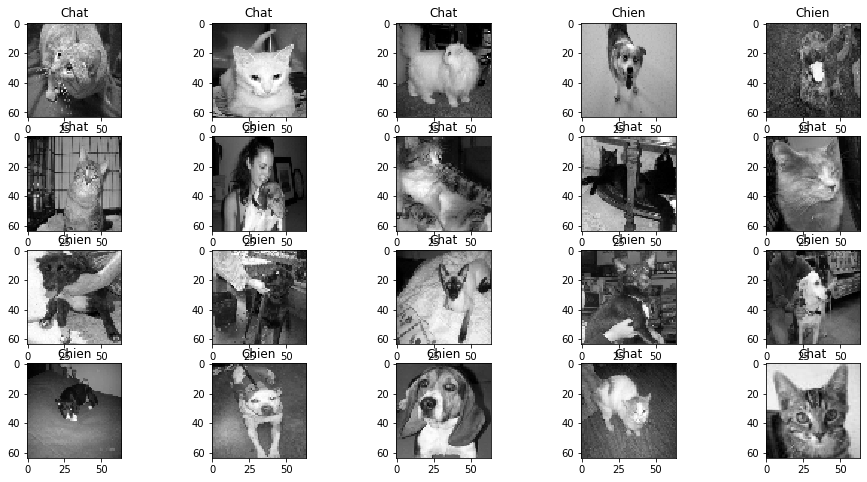

In [36]:
# Affichons quelques photos : 

def affichePhoto(n): 
    plt.figure(figsize=(16,8))
    for i in range(1,n+1): 
        plt.subplot(4,5,i)
        plt.imshow(X[i],cmap='gray')
        plt.title("Chat" if y[i]==0 else "Chien")
    plt.show()

affichePhoto(20)

#Attention : Ne peut pas afficher plus de 20 photos. 

In [11]:
'''
Une fois aplatie, chaque photo est un vecteur de 4096 pixels, 
donc 4096 variables qui prennent des valeurs entre 0 et 255 (1 pixel = 8 bits). 
'''

In [45]:
# On commence donc par applatir nos images pour en faire un vecteur de 1000 lignes et 4096 caractéristiques
# Pour être sûre des dimensions sur lequels on travaille, je les affiche.  

print("Avant applatissement :")
print("X:",X.shape," Xtest=", Xtest.shape)


Xr=X.reshape(X.shape[0],X.shape[1]*X.shape[2])
Xt=Xtest.reshape(Xtest.shape[0],Xtest.shape[1]*Xtest.shape[2])

print()
print("Après applatissement :")
print("Xr:",Xr.shape," Xt=", Xt.shape)

#OK. 

Avant applatissement :
X: (1000, 64, 64)  Xtest= (200, 64, 64)

Après applatissement :
Xr: (1000, 4096)  Xt= (200, 4096)


In [27]:
print(Xr)

[[164 174 163 ...  87 180  39]
 [ 42  43  39 ...  55  52  55]
 [ 27  26  29 ... 135 141 121]
 ...
 [ 47  68 142 ... 202 202 203]
 [252 252 252 ...  64  66  59]
 [122 126 130 ... 161 160 160]]


### Perceptron d'un neurone :

In [16]:
# Il n'y a plus qu'à entraîner notre modèle avec ces données !

In [46]:
# On initialise les paramètres du perceptron, pour une couche.
def initParam(n):
    W=np.random.randn(n,1)
    b=np.random.randn(1)
    return (W,b)

In [47]:
W,b = initParam(Xr.shape[1])

print(W.shape,b.shape,b)

(4096, 1) (1,) [-0.22683552]


In [48]:
# On définit notre modèle. 

def perceptron(X,W,b):
    # On applique nos formules vectorisées.
    z=X.dot(W)+b
    A=1/(1+np.exp(-z))
    return A


#On initialise notre perceptron sur les données d'apprentissage Xr. 
A=perceptron(Xr,W,b)
print(A.shape)

(1000, 1)


#### Fonction de prédiction.

In [65]:
def predict(X,W,b):
    return perceptron(X,W,b)>0.5

In [50]:
''' Cette fonction ne semble pas avoir servi quelque part. '''
def prodScal(U,V):
     return np.sum(U*V)

#### Performance du modèle et fonction d'erreur.

In [51]:
'''
On évalue la performance du modèle. 
On minimisera avec l'erreur quadratique; avec la fonction ci-dessous: 
'''

def coutErrQ(A,y): 
    m=len(A)
    return np.sum((A-y)**2)/m

print(coutErrQ(A,y))

0.508


In [52]:
'''
Fonction du rapport avec le Log Loss cette fois-ci. 
'''

def logLoss(A,y): 
    m=len(y)
    eps=1e-15
    return -(np.sum(y*np.log(A+eps)+(1-y)*np.log(1-A+eps)))/m

print(logLoss(A,y))

17.545698408614705


#### Calcul du gradient. 

In [58]:
# On détermine le gradient : 


def gradient(A,X,y):
    ''' Descente de gradient pour l'erreur quadratique. '''
    m=len(y)
    
    dw= np.dot(X.T,(A-y)*A*(1-A)) / m
    db =np.sum(((A-y)*(A)*((1-A)))) / m 
    
    return (dw,db)


dW,db=gradient(A,Xr,y)
print(dW,db)


def gradient_LogLoss(A,X,y): 
    ''' Descente de gradient avec le Log Loss, pour tester les différences. '''
    
    m = len(y)
    
    dw = np.dot(X.T,(A-y)) /m
    db = np.sum( (A-y)) /m
    
    
    return (dw,db)

print()
#print(gradient_LogLoss(A,Xr,y))

[[1.26696098e-21]
 [1.25429137e-21]
 [1.25429137e-21]
 ...
 [3.48414271e-22]
 [3.35744661e-22]
 [4.30766734e-22]] 6.334804918278069e-24



##### Propagation arrière. 

In [64]:
# on met à jour les paramètres par descente de gradient
def mAj(dW,db,W,b,alpha):
    
    W=W-alpha*dW
    b=b-alpha*db
    
    return (W,b)


ww,dd=mAj(dW,db,W,b,0.1) 


print("dd=",dd.shape,"ww=",ww.shape)

dd= (1,) ww= (4096, 1)


In [74]:
# On définit notre fonction d'apprentissage
# On fait une propagation arrière par descente de gradient. 


#Fonction avec l'erreur quadratique : 

def learnRN(X,y,alpha=0.1, iter=100): 
    m=X.shape[1]
    W,b=initParam(m)
    LECOUT=[]
    
    for i in range(iter):
        A=perceptron(X,W,b)
        
        LECOUT.append(coutErrQ(A,y))
        
        dW,db=gradient(A,X,y) #Calcul des gradients
        W,b=mAj(dW,db,W,b,alpha) #Mise à jour des paramètres ! :)    
   

    plt.plot (LECOUT)  # On trace la courbe de descente des couts 
    plt.show()
   
    
    return W,b


In [76]:
def creation_module(mode,X,y,alpha=0.1,iter=100): 
    '''
    Le mode permet de choisir si l'on veut : 
    - Soit maximiser la vraissemblance avec le log loss : "LL"
    - Soit minimiser l'erreur quadratique : "EQ"
    '''
    
    m=X.shape[1]
    W,b=initParam(m)

    if mode=='EQ': #Erreur quadratique. 
        LECOUT=[]
        
        for i in range(iter):
            #On définit le perceptron. 
            A=perceptron(X,W,b)
            
            #Calcul du coût avec l'erreur quadratique. 
            LECOUT.append(coutErrQ(A,y))
            
            #Calcul des gradients
            dW,db=gradient(A,X,y) 
            W,b=mAj(dW,db,W,b,alpha) #Mise à jour des paramètres ! :)    


        plt.plot (LECOUT)  # Traçage de la courbe de descente des coûts. 
        plt.show()
        
        return W,b
        
    elif mode=='LL': #Log Loss 
        COUT_LL=[]
        
        for i in range(iter):
            #On définit le perceptron. 
            A=perceptron(X,W,b)
            
            #Calcul du coût avec le Log Loss. 
            COUT_LL.append(logLoss(A,y))
            
            #Calcul des gradients
            dW,db=gradient_LogLoss(A,X,y) 
            W,b=mAj(dW,db,W,b,alpha) #Mise à jour des paramètres ! :) 
            
        plt.plot (COUT_LL)  # Traçage de la courbe de descente des coûts. 
        plt.show()
            
        return W,b
        
    else: #Mode choisi pas connu. 
        print("On ne peut choisir que l'erreur quadratique ou le log loss.")
        raise
    


#### Tests de quelques créations de module.

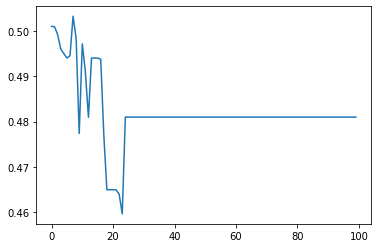

In [87]:
#Erreur quadratique.
W,b=creation_module("EQ",Xr,y)

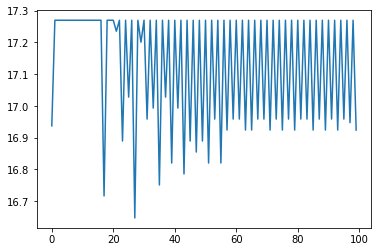

In [90]:
#Log Loss.
W,b=creation_module("LL",Xr,y)

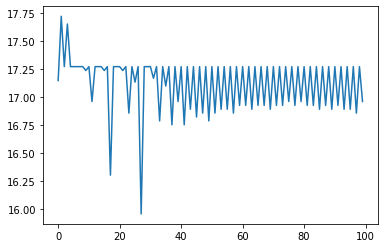

In [94]:
#Log Loss.
W,b=creation_module("LL",Xr,y)

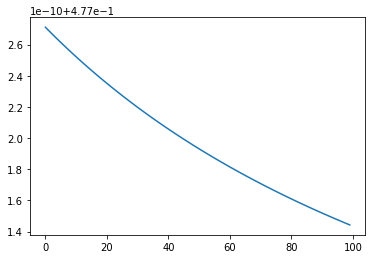

In [91]:
#Erreur quadratique.
W,b = learnRN(Xr,y)

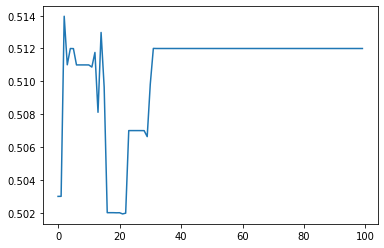

In [93]:
#Erreur quadratique. 
W,b = learnRN(Xr,y)

In [ ]:
'''
On observe différents résultats à chaque nouveau 'module', ainsi qu'une différence très notable entre le choix entre 
maximisation avec le Log Loss et la minimisation de l'erreur quadratique. 
'''

### Normalisation des données :

In [95]:
#On normalise sur les données d'entrainement et de tests. 
#Cette normalisation aurait pu se faire dès le départ. 

def normaliser(Xr,Xt): 
    return Xr/255, Xt/255

Xn,Xtn= normaliser(Xr,Xt)

print(Xn.shape)
print(Xn.max(),Xn.min()) 

(1000, 4096)
0.996078431372549 0.0


#### Quelques tests après normalisation. 

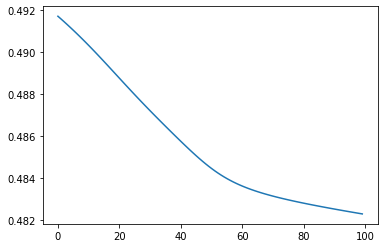

In [96]:
W,b = learnRN(Xn,y)

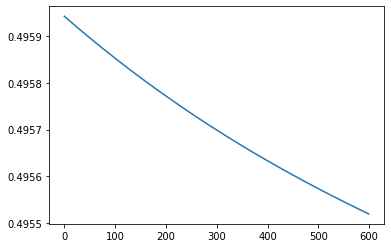

In [100]:
# Voila qui est bien mieux ! 
W,b = learnRN(Xn,y,alpha=0.01,iter=600)

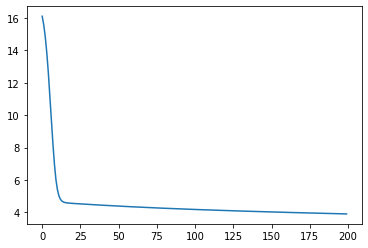

In [105]:
#log Loss.
W,b = creation_module("LL",Xn,y,alpha=0.01,iter=200)

## • Partie II : Test de performance du modèle avec sklearn. •

In [111]:
# Nous y voilà!
# Quelle est alors la performance du modèle?
from sklearn.metrics import accuracy_score

In [112]:
'''
On modifie la fonction d'apprentissage pour afficher les courbes de coûts et les performances du modèle.
'''

def learnRN(X,y,alpha=0.1, iter=100): 
    '''
    Fonction pour l'erreur quadratique.
    '''
    
    m=X.shape[1]
    W,b=initParam(m)
    LECOUT=[]
    Accu=[]
    
    for i in range(iter): 
        A=perceptron(X,W,b)
        LECOUT.append(coutErrQ(A,y))
        
        #Calcul erreur quadratique et score du modèle. 
        pred=predict(X,W,b)
        p=accuracy_score(y,pred)
        Accu.append(p)
        
        dW,db=gradient(A,X,y) #Propagation arrière avec les gradients
        W,b=mAj(dW,db,W,b,alpha) #MAJ des paramètres.
    
    
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot (LECOUT)  # On trace la courbe de descente des couts 
    plt.subplot(1,2,2)
    plt.plot(Accu) # et l'accuracy 
    plt.show()
    
    
    return W,b

In [122]:
'''
Petit complément : De même, on ajoute une option pour avoir les performances avec le modèle choisi du Log Loss. 
'''


def module_perf(mode,X,y,alpha=0.1,iter=100): 
    '''
    Le mode permet de choisir si l'on veut : 
    - Soit maximiser la vraissemblance avec le log loss : "LL"
    - Soit minimiser l'erreur quadratique : "EQ"
    '''
    
    m=X.shape[1]
    W,b=initParam(m)

    if mode=='EQ': #Erreur quadratique. 
        LECOUT=[]
        Accu=[]
        
        for i in range(iter):
            #On définit le perceptron. 
            A=perceptron(X,W,b)
            
            #Calcul du coût avec l'erreur quadratique. 
            LECOUT.append(coutErrQ(A,y))
            
            #Calcul score du modèle. 
            pred=predict(X,W,b)
            p=accuracy_score(y,pred)
            Accu.append(p)
            
            #Calcul des gradients
            dW,db=gradient(A,X,y) 
            W,b=mAj(dW,db,W,b,alpha) #Mise à jour des paramètres ! :)    


        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        plt.plot (LECOUT)  # On trace la courbe de descente des coûts.
        plt.title("Coût") 
        plt.subplot(1,2,2)
        plt.plot(Accu) # et de l'accuracy.
        plt.title("Accuracy") 
        plt.show()
        
        return W,b
        
    elif mode=='LL': #Log Loss 
        COUT_LL=[]
        Accu=[]
        
        for i in range(iter):
            #On définit le perceptron. 
            A=perceptron(X,W,b)
            
            #Calcul du coût avec le Log Loss. 
            COUT_LL.append(logLoss(A,y))
            
            #Calcul score du modèle. 
            pred=predict(X,W,b)
            p=accuracy_score(y,pred)
            Accu.append(p)
            
            #Calcul des gradients
            dW,db=gradient_LogLoss(A,X,y) 
            W,b=mAj(dW,db,W,b,alpha) #Mise à jour des paramètres ! :) 
            
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        # On trace la courbe de descente des coûts.
        plt.plot (COUT_LL)
        plt.title("Coût") 
        plt.subplot(1,2,2)
        # et de l'accuracy. 
        plt.plot(Accu)
        plt.title("Accuracy.")
        plt.show()
            
        return W,b
        
    else: #Mode choisi pas connu. 
        print("On ne peut choisir que l'erreur quadratique ou le log loss.")
        raise
    

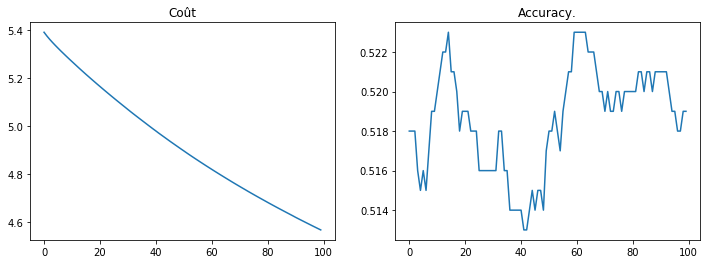

In [123]:
W,b=module_perf("LL",Xn,y,alpha=0.01)

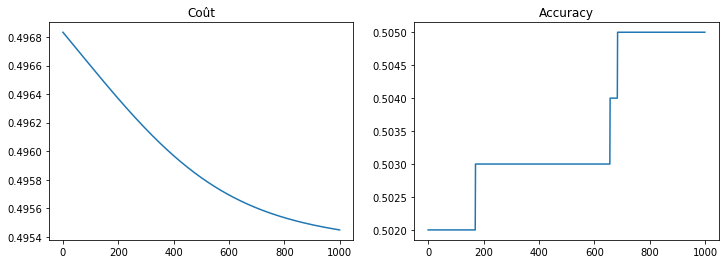

In [126]:
W,b=module_perf("EQ",Xn,y,alpha=0.01,iter=1000)

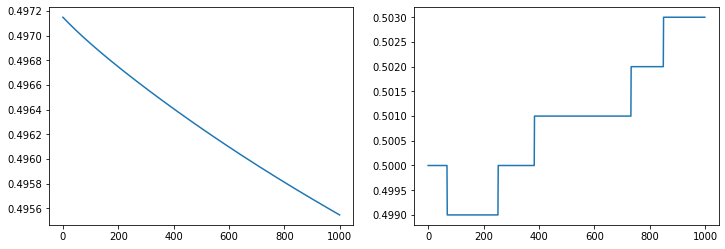

In [124]:
#Erreur quadratique.
W,b = learnRN(Xn,y,alpha=0.01,iter=1000)

In [ ]:
'''
On serait tenté d'aller plus loin car l'accuracy continue d'augmenter...
La courbe augmente jusqu'à un point avoisinant les 50% puis redescendrait.. 
'''

In [ ]:
# Ne serait-on pas en overfitting? 
#Il est temps de regarder ce qui se passe sur les datas de test !

### Ajout des données de test. 

In [132]:
'''
Fonction avec l'erreur quadratique. 
'''

def learnRN(X,y,Xt,yt,alpha=0.1, iter=100): # on ajoute les données de test
    m=X.shape[1]
    W,b = initParam(m)
    
    #Listes des performances du modèles
    LECOUT=[]
    Accu=[]
    #Listes des performances lors du test
    COUT_TEST=[]
    Accu_TEST=[]
    
    for i in range(iter): 
        A=perceptron(X,W,b)
        if i%10==0: #On prend le choix de ne calculer les scores qu'un résultat sur 10. 
            
                #Modèle : 
            LECOUT.append(coutErrQ(A,y))

            #Calcul erreur quadratique et score du modèle. 
            pred=predict(X,W,b)
            p=accuracy_score(y,pred)
            Accu.append(p)
            
                #Test : 
            A_TEST=perceptron(Xt,W,b)
            COUT_TEST.append(coutErrQ(A_TEST,yt))
            
            pred_t=predict(Xt,W,b)
            pt=accuracy_score(yt,pred_t)
            Accu_TEST.append(pt)
            

        dW,db=gradient(A,X,y) #Propagation arrière avec les gradients
        W,b=mAj(dW,db,W,b,alpha) #MAJ des paramètres.
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.title("Coût.")
    plt.plot (LECOUT,label='Données d''entraînement')  # On trace la courbe de descente des couts 
    plt.plot (COUT_TEST,label='Données de test')
    plt.legend()
    plt.subplot(1,2,2)
    plt.title("Accuracy.")
    plt.plot(Accu,label='Données d''entraînement') 
    plt.plot(Accu_TEST,label='Données de test')
    plt.legend()
    plt.show()
    
    
    return W,b

In [133]:
'''
Fonction avec la vraissemblance et le Log Loss. 
'''

def learnLL(X,y,Xt,yt,alpha=0.1, iter=100): # on ajoute les données de test
    m=X.shape[1]
    W,b = initParam(m)
    
    #Listes des performances du modèles
    LECOUT=[]
    Accu=[]
    #Listes des performances lors du test
    COUT_TEST=[]
    Accu_TEST=[]
    
    for i in range(iter): 
        A=perceptron(X,W,b)
        if i%10==0: #On prend le choix de ne calculer les scores qu'un résultat sur 10. 
            
                #Modèle : 
            LECOUT.append(logLoss(A,y))

            #Calcul erreur quadratique et score du modèle. 
            pred=predict(X,W,b)
            p=accuracy_score(y,pred)
            Accu.append(p)
            
                #Test : 
            A_TEST=perceptron(Xt,W,b)
            COUT_TEST.append(logLoss(A_TEST,yt))
            
            pred_t=predict(Xt,W,b)
            pt=accuracy_score(yt,pred_t)
            Accu_TEST.append(pt)
            

        dW,db=gradient_LogLoss(A,X,y) #Propagation arrière avec les gradients
        W,b=mAj(dW,db,W,b,alpha) #MAJ des paramètres.
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.title("Coût.")
    plt.plot (LECOUT,label='Données d''entraînement')  # On trace la courbe de descente des couts 
    plt.plot (COUT_TEST,label='Données de test')
    plt.legend()
    plt.subplot(1,2,2)
    plt.title("Accuracy.")
    plt.plot(Accu,label='Données d''entraînement') 
    plt.plot(Accu_TEST,label='Données de test')
    plt.legend()
    plt.show()
    
    
    return W,b


### Quelques tests avec différents paramètres alpha et plusieurs nombre d'itérations :

#### Avec l'erreur quadratique : 

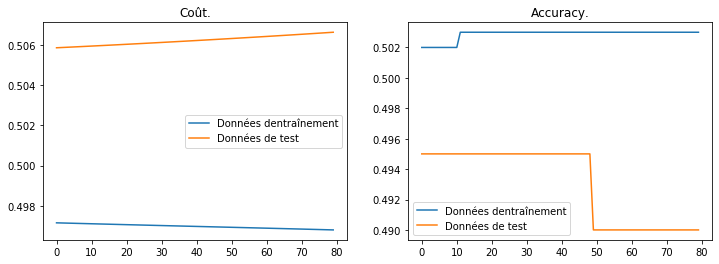

In [136]:
W,b = learnRN(Xn,y,Xtn,yt,alpha=0.01,iter=800)

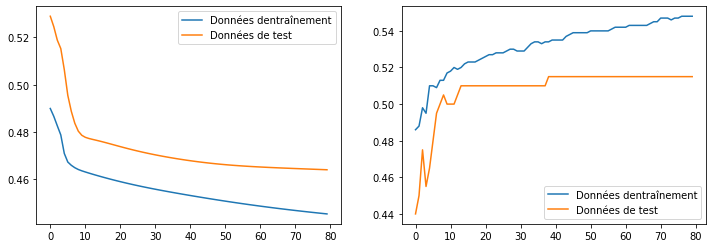

In [45]:
W,b = learnRN(Xn,y,Xtn,yt,alpha=0.1,iter=800)

#On plafonne vers 0.55 (55%), il y a surement un problème d'overfitting.

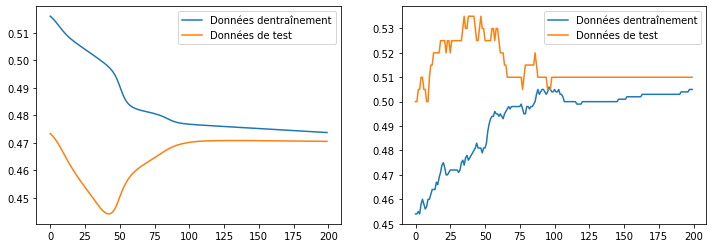

In [46]:
W,b = learnRN(Xn,y,Xtn,yt,alpha=0.01,iter=2000)

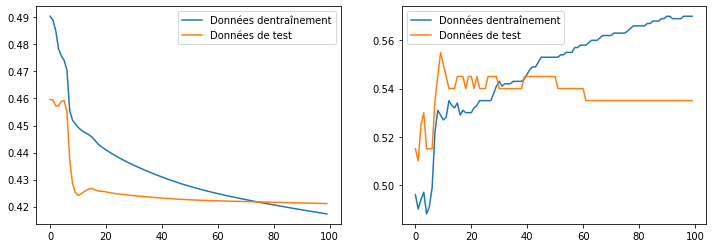

In [47]:
W,b = learnRN(Xn,y,Xtn,yt,alpha=0.1,iter=1000)

In [143]:
'''
On n'a pas assez de données pour le nombre de caractéristiques (Fléau de la dimension).
Il faut réduire le nombre de variables ou augmenter le nombre de données.
Mais surtout... Augmenter le nombre de neurones! pour obtenir un réseau de neurones multicouche.


Dans la plupart des cas, il y a un plafond vers les 50-55%. 

'''
print()

#### Avec la vraissemblance :

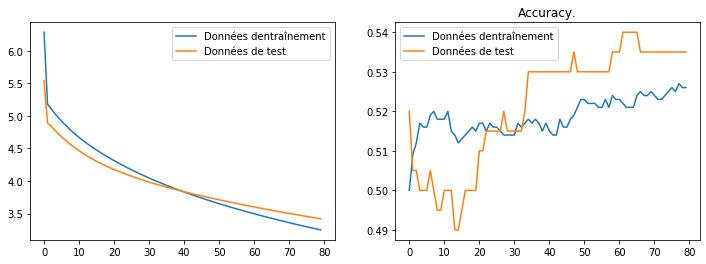

In [130]:
W,b = learnLL(Xn,y,Xtn,yt,alpha=0.01,iter=800)

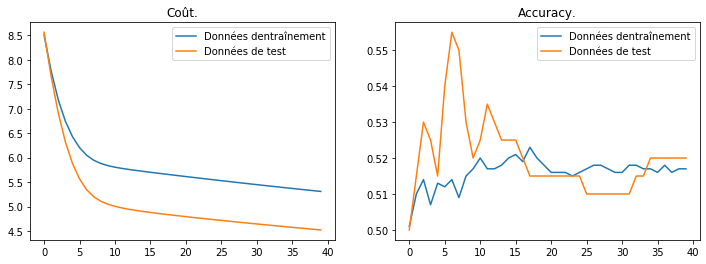

In [144]:
W,b = learnLL(Xn,y,Xtn,yt,alpha=0.001,iter=400)

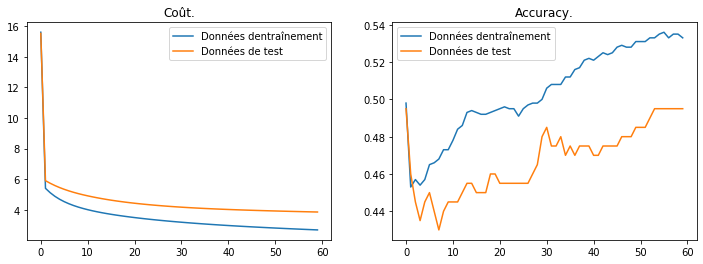

In [148]:
W,b = learnLL(Xn,y,Xtn,yt,alpha=0.025,iter=600)

## • Partie III : A l'aide d'un PMC. •


On utilisera ici la bibliothèque sklearn pour faire un apprentissage d'un perceptron. 

In [153]:
Xa, Ya, Xt, Yt = load_data() # chargement des training data et des test data

In [154]:
# On applatit et on normalise les données
Xa=Xa.reshape(Xa.shape[0],Xa.shape[1]*Xa.shape[2])
Xt=Xt.reshape(Xt.shape[0],Xt.shape[1]*Xt.shape[2])

print(Xa.shape,Ya.shape,Xt.shape,Yt.shape) 

#Normalisation : 

Xa,Xt=normaliser(Xa,Xt)

(1000, 4096) (1000, 1) (200, 4096) (200, 1)


In [161]:
from sklearn.neural_network import MLPClassifier

# On commence avec les paramètres par défaut :
clf = MLPClassifier(max_iter=1000, random_state=0)

# Apprentissage avec les deux dernières variables
clf.fit(Xa, Ya)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=0, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [162]:
# On calcule les scores d'apprentissage et de test.
train_score = clf.score(Xa, Ya)
print("Le score sur les données d'apprentissage est {}".format(train_score))
test_score = clf.score(Xt, Yt)
print("Le score sur les données de test est {}".format(test_score))

Le score sur les données d'apprentissage est 0.781
Le score sur les données de test est 0.535


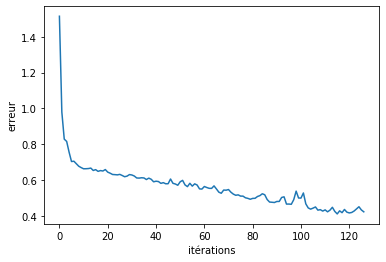

In [163]:
plt.figure()
plt.xlabel('itérations')
plt.ylabel('erreur')
plt.plot(clf.loss_curve_)
plt.show()

In [ ]:
# 1 chance sur 2, Vraiment pas terrible! Et ce n'est pas un problème de nombre d'itérations
# Regardons comment cela varie avec le nombre de neurones dans une couche intermédiaire.

#### Perceptron avec deux neurones : 

C:\Users\Utilisateur\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Le score sur les données d'apprentissage est 0.96
Le score sur les données de test est 0.54


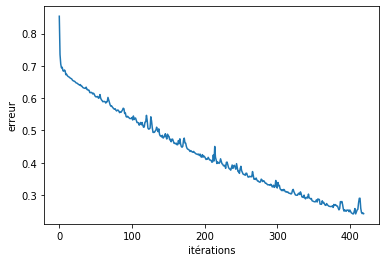

In [164]:
clf = MLPClassifier(hidden_layer_sizes=(2,), solver='adam', max_iter=1000, random_state=0)
clf.fit(Xa, Ya)

# On calcule les scores d'apprentissage et de tes
train_score = clf.score(Xa, Ya)
print("Le score sur les données d'apprentissage est {}".format(train_score))
test_score = clf.score(Xt, Yt)
print("Le score sur les données de test est {}".format(test_score))


plt.figure()
plt.xlabel('itérations')
plt.ylabel('erreur')
plt.plot(clf.loss_curve_)
plt.show()

#### Perceptron avec couches de dix neurones : 

In [165]:
"""
Tests avec 11 couches de 10 neurones chacuns :

On s'approche des 60% avec un 58%. 
Suite à plusieurs tests, si l'on rajoute des couches supplémentaires de 10 neurones 
On diminue le score sur les données de tests. 


"""

clf = MLPClassifier(hidden_layer_sizes=(10,10,10,10,10,10,10,10,10,10,10), solver='adam', max_iter=1000, random_state=0)
clf.fit(Xa, Ya)

# On calcule les scores d'apprentissage et de tes
train_score = clf.score(Xa, Ya)
print("Le score sur les données d'apprentissage est {}".format(train_score))
test_score = clf.score(Xt, Yt)
print("Le score sur les données de test est {}".format(test_score))



C:\Users\Utilisateur\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Le score sur les données d'apprentissage est 0.903
Le score sur les données de test est 0.58


C:\Users\Utilisateur\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Le score sur les données d'apprentissage est 0.942
Le score sur les données de test est 0.595


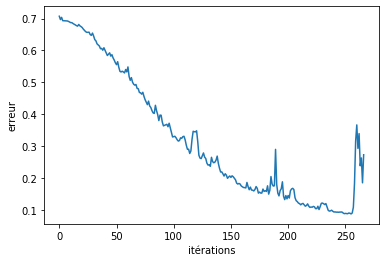

In [166]:
# On a du mal à dépasser 60% sur les données de test, c'est notre challenge

clf = MLPClassifier(hidden_layer_sizes=(10,20), solver='adam', max_iter=1000, random_state=0)
clf.fit(Xa, Ya)

# On calcule les scores d'apprentissage et de tes
train_score = clf.score(Xa, Ya)
print("Le score sur les données d'apprentissage est {}".format(train_score))
test_score = clf.score(Xt, Yt)
print("Le score sur les données de test est {}".format(test_score))


plt.figure()
plt.xlabel('itérations')
plt.ylabel('erreur')
plt.plot(clf.loss_curve_)
plt.show()


#On arrive à peu près vers du 59%...

#### Test avec une activation sigmoïde.

In [168]:
# Essayons avec une activation sigmoide :

clf = MLPClassifier(hidden_layer_sizes=(2,10), activation='logistic', max_iter=1000, random_state=0)
clf.fit(Xa, Ya)

# On calcule les scores d'apprentissage et de tes
train_score = clf.score(Xa, Ya)
print("Le score sur les données d'apprentissage est {}".format(train_score))
test_score = clf.score(Xt, Yt)
print("Le score sur les données de test est {}".format(test_score))


C:\Users\Utilisateur\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Le score sur les données d'apprentissage est 0.973
Le score sur les données de test est 0.555


In [169]:
clf = MLPClassifier(hidden_layer_sizes=(2,10), activation='logistic', max_iter=2000, random_state=0)
clf.fit(Xa, Ya)

# On calcule les scores d'apprentissage et de tes
train_score = clf.score(Xa, Ya)
print("Le score sur les données d'apprentissage est {}".format(train_score))
test_score = clf.score(Xt, Yt)
print("Le score sur les données de test est {}".format(test_score))

C:\Users\Utilisateur\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Le score sur les données d'apprentissage est 0.973
Le score sur les données de test est 0.555


In [ ]:
# Difficile d'avoir mieux que 60% Il faudrait augmenter le nombre d'itérations mais c'est long...
# A moins de commencer par réduire le nombres de variables... A suivre

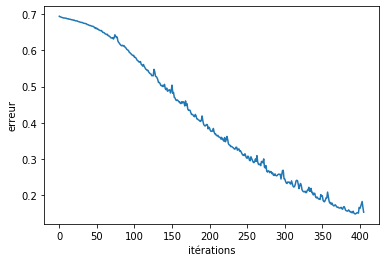

In [170]:
plt.figure()
plt.xlabel('itérations')
plt.ylabel('erreur')
plt.plot(clf.loss_curve_)
plt.show()

In [172]:
'''
Remarque et 'conclusion' : 

L'idée générale est qu'il n'y a pas assez de variables mais trop de données ici pour que le modèle fonctionne réellement. 
Cela fait un quasi ~ 50/50 sur la reconnaissance du type chat ou chien. 

Le modèle MLP n'est sûrement pas le meilleur modèle pour la classification de photos ici, il faudrait s'intéresser à 
des modèles plus complexes (ce qui sera très certainement le cas dans un futur proche). 

'''

## • Partie IV : Réduction de variables avec APC •

In [ ]:
'''
Dans cette partie, on appliquera la méthode vue en cours, de la réduction du nombres de variables par analyse en composantes 
principales (APC).

On devra tout d'abord standardiser les données, puis déterminer la matrice de corrélation. 
Ensuite trouver les valeurs et vecteurs propres de la matrice symétrique...

'''

### Standardisation des données et matrice de corrélation.

In [213]:
#Chargement des données puis redimensionner.

Xa, ya, Xt, yt = load_data()
Xa=Xa.reshape(Xa.shape[0],Xa.shape[1]*Xa.shape[2])
Xt=Xt.reshape(Xt.shape[0],Xt.shape[1]*Xt.shape[2])

#On concatène. 
X=np.concatenate((Xa,Xt),axis=0)
y=np.concatenate((ya,yt),axis=0)

print("X=",X.shape," y=",y.shape) #Affichage des dimensions pour être sûre après la concaténation. 

'''------------------------'''

#Standardisation :
def standardiser(X): 
    return (X-np.mean(X,axis=0))/np.std(X,axis=0)

X= (1200, 4096)  y= (1200, 1)


In [214]:
#Tests : 

print("Avant standardisation :")
print("Moyenne:",np.mean(X),"Std:",np.std(X))

X=standardiser(X)
print()

print("Après standardisation :")
print("Moyenne:",np.mean(X),"Std:",np.std(X))

Avant standardisation :
Moyenne: 117.58331827799479 Std: 64.36137764982327

Après standardisation :
Moyenne: 7.170190367370803e-19 Std: 1.0000000000000004


In [216]:
#Matrice de corrélation : 

def matrice_correlation(X,precision):
    M=np.round(np.corrcoef(X.T),precision)
    while not np.array_equal(M,M.T):
        '''
        Vérification de la symétrie de la matrice, car il peut y avoir des erreurs à cause de la précision. 
        Cela s'est vérifié sur de nombreux tests avant de comprendre que cela venait de là. 
        '''
        precision-=1
        M=np.round(np.corrcoef(X.T),precision)
    return M

#Valeur par défaut de la précision. 
precision=15 

M=matrice_correlation(X,precision)
print(M.shape)
#print(M[5:,5:]) 
#Ok, nous avons bien une matrice symétrique ! 

(4096, 4096)


In [218]:
#Cherchons les valeurs et vecteurs propres de cette matrice symétrique. 

Val_P,P = np.linalg.eig(M) #compute the eigenvalues and right eigenvectors of a square array.
#Vérification des dimensions pour l'analyse : 
print("Valeurs :",Val_P.size)
print("Vecteurs:",P.shape)

Valeurs : 4096
Vecteurs: (4096, 4096)


### Partie d'Analyse.

In [248]:
'''
Dans la méthode d'analyse en composantes principales, on devra calculer l'inertie et la 
décroissance des valeurs propres (on parle parfois d'éboulis des valeurs propres, dans certains documents).

On va alors définir des fonctions qui permettront de les calculer. 
'''

#Eboulis des valeurs propres : 

def decroissance_vp(n,val_propres):
    r=list(range(1,n+1))
    return r,[ val_propres[n-1] for n in r]


#Calcul de l'inertie : 

def inertie(n,val_propres): #Calcul d'une seule inertie choisie.
    return np.sum(val_propres[:n])/(np.sum(val_propres)) #On divise la somme des n vp par le total des valeurs propres. 

def inerties(n,val_propres):
    r=list(range(n+1))
    return r,[ inertie(n,val_propres) for n in r] #Calcul de toutes les inerties. 


'''
On va essayer par la suite de visualiser avec des courbes l'inertie et les éboulis.
Selon l'inertie qui sera observée, on pourra en choisir une et conserver un nombre fini de premiers vecteurs qui sont 
réellement significatifs. 
'''

def visualisation(n,val_propres):
    
    RD,dec_vp=decroissance_vp(n,val_propres) #Décroissance des valeurs propres.
    RI,inertie=inerties(n,val_propres) #Calcul des différentes inerties. 
    
    f,axes=plt.subplots(1,2) #On affichera côte à côte les deux courbes.
    f.set_figheight(4)
    f.set_figwidth(12)
    
    #Affichage de la décroissance des valeurs propres des n premières composantes. 
    
    
    axes[0].set_title('Éboulis ')
    axes[0].set_xlabel('n premières composantes') 
    axes[0].set_ylabel('Décroissance des valeurs propres')
    axes[0].bar(RD,dec_vp,1)
    axes[0].plot(RD,dec_vp)
    
    
    #Affichage des inerties des n premières composantes. 
    
    axes[1].set_title('Inerties ')
    axes[1].set_xlabel('n premières composantes') 
    axes[1].set_ylabel('Inertie des valeurs propres')
    axes[1].plot(RI,inertie)


#### Visualisation et choix des n premières composantes. 

n= 120 Inertie: 0.864


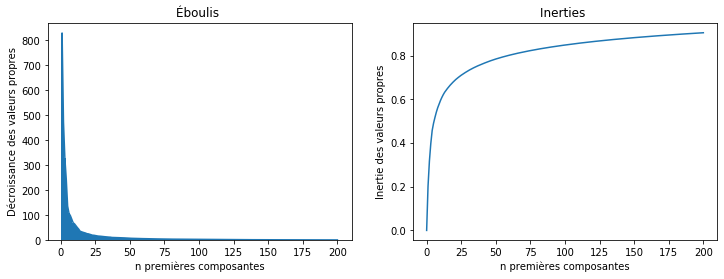

In [262]:
'''
Essayons de visualiser et de trouver une valeur n correspondant aux n premières composantes, que l'on pourrait garder.
'''

visualisation(200,Val_P)

#On va essayer de garder les n=120 premières composantes par la suite. 

In [285]:
'''
Testons de prendre n=120, en conservant seulement un nombre de 120 variables on atteint environ 86% d'inertie.   
'''

n=120
print("Inertie :", round(inertie(n,Val_P),3),"pour",n,"variables.")
print()

#On ne conserve alors que les 120 premiers vecteurs : 

P2=P[:,:n] #Nouveau vecteur des vecteurs propres. 


"----------------------------------"

#On vérifie les shapes pour les calculs que l'on devra faire ensuite : 
print("Dimensions : ")
print("P :", P.shape)
print("P2 :", P2.shape)
print()
print("X :", X.shape)



Inertie : 0.864 pour 120 variables.

Dimensions : 
P : (4096, 4096)
P2 : (4096, 120)

X : (1200, 4096)


### Transformation, projection des données et visualisation. 

In [296]:
'''
Formules : 

NX=X*P2 
#NX -> Nouveau X, après transformation. 

AX=NX*T.P2=NX*P2^-1 | car P2^-1 = T.P2 <- ! 
#AX -> Ancien X, que l'on pourra utiliser pour essayer de se mettre à la place de notre modèle.

(Cela est assez illisible de l'écrire en commentaire de cette façon..)
'''

NX=np.dot(X,P2)
#Dimension du nouveau X.
print("NX :",NX.shape) 


NX : (1200, 120)


In [298]:
n=120 #On récupérera les n=120 premières lignes. 

'''
Récap variables : 
TP= #Matrice de passage inverse, car c'est simplement sa transposée comme indiqué avec les formules. 
AX= Ancien X
NX= Nouveau X
'''

TP=P.T[:NX.shape[1],:]

AX=np.dot(NX,TP) 

images_IA=AX.reshape(1200,64,64)

print("T.P:",TP.shape)
print("Ancien X:", AX.shape)

T.P: (120, 4096)
Ancien X: (1200, 4096)


#### Essayons de nous mettre à la place de l'IA, une fois les photos modifiées ! 

In [302]:
#Chargement des images d'origine pour la comparaison. 
Xa, ya, Xt, yt = load_data() 
images=np.concatenate((Xa,Xt),axis=0)


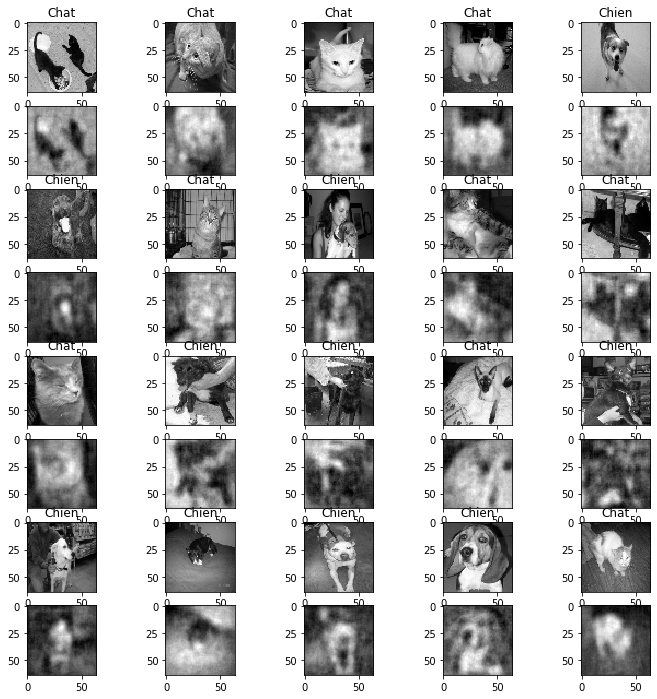

In [321]:
#Comparons les images d'origines avec ce que l'IA voit une fois la modification faite. 

f,axes=plt.subplots(8,5)
f.set_figheight(12)
f.set_figwidth(12)

nb=0

for i in range(4): #lignes
    for j in range(5): #colonnes
        
        axes[2*i,j].set_title("Chat" if int(ya[nb][0])==0 else "Chien")
        axes[2*i,j].imshow(images[nb],cmap='gray')
        axes[2*i+1,j].imshow(images_IA[nb],cmap='gray')
        
        nb+=1
        
plt.show()


In [ ]:
'''
Le resultat est assez interessant à observer : La vision de l'IA est semblable à celle d'un myope. 

Pour certaines photos, il est encore 'facile' de deviner si c'est un chien ou un chat avec la forme, mais d'autres ne sont
plus que du gris avec des taches noirs indiscernables. 

Les photos avec des élements autres que l'animal sont sûrement les plus compliquées. 


'''